# Creating a Kaggle Workflow

This project is about creating a Kaagle competition workflow. You might use when analyzing the data. Usually you want to iterate over different models. Then using different parameters for each. All the process aims to find the best estimator and parameter set.

You'll be able to interact on ideas quicker and easier. This allows yourself to work more efficient.

## Project Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [23]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
print('train has {} rows by {} columns'.format(train.shape[0], train.shape[1]))
print('test has {} rows by {} columns'.format(holdout.shape[0], holdout.shape[1]))

train has 891 rows by 12 columns
test has 418 rows by 11 columns


Test has no target column 'Survived'. This is on purpose, since kaagle hides this information. You are able to test your model accuracy only in the Kaagle website.

In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
holdout.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


## Helper functions

In [6]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [7]:
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    dummies_cols = ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]
    df = create_dummies(df, dummies_cols)
    
    return df

We'll apply the `process_df()` method to both train and holdout (or test) dataframes:

In [8]:
train = process_df(train)
holdout = process_df(holdout)

## Exploring the data

We will explore two features in the following part of this project: _SibSp_ and _Parch_. **SibSp** is the number of siblings and/or spouses the passenger had on board. **Parch** shows the number of parents and/or children the passenger had on board. We could sum all together as a new feature called 'relatives' and see if this helps on the modeling process.

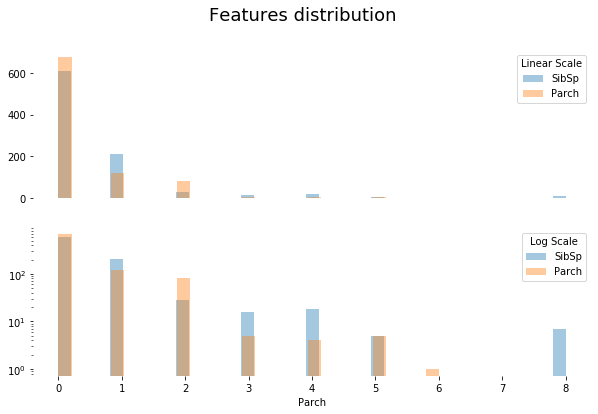

In [9]:
f, ax = plt.subplots(2,1, figsize=(10,6))

sns.distplot(a=train['SibSp'], kde=False, ax=ax[0])
sns.distplot(a=train['Parch'], kde=False, ax=ax[0])
sns.distplot(a=train['SibSp'], kde=False, ax=ax[1])
sns.distplot(a=train['Parch'], kde=False, ax=ax[1])

sns.despine()
sns.despine(ax=ax[0], left=True, bottom=True)
sns.despine(ax=ax[1], left=True, bottom=True)

ax[0].set_yscale('linear')
ax[0].set_xticks([])
ax[0].set_xlabel('')
ax[1].set_yscale('log')

f.suptitle('Features distribution', size=18)
ax[0].legend(title='Linear Scale', loc='upper right', labels=['SibSp', 'Parch'])
ax[1].legend(title='Log Scale', loc='upper right', labels=['SibSp', 'Parch'])

Text(0, 0.5, 'Passengers')

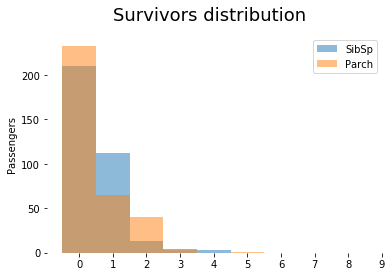

In [10]:
sub_train = train[['SibSp', 'Parch', 'Survived']]
survivors = sub_train['Survived'] == 1

sub_train[survivors].drop('Survived', axis=1).plot.hist(bins=np.arange(10)-0.5, alpha=0.5)
plt.xticks(np.arange(10))
plt.suptitle('Survivors distribution', size=18)
sns.despine(left=True, bottom=True)
plt.ylabel('Passengers')

### Family Clusters

We have to take care that we should cluster families to understand whether these features are an insight or not. Lets create a new column **'Relatives'** which is the sum of 'SibSp' and 'Parch'.

I will elaborate an example with _Mr. John_. He has 2 children and 1 Spouse, _Mrs. Sonya_. Sadly one of their children didn't survive. We should observe the following table:

|Name|SibSp|Parch|_Relatives_|Survived|
|---|---|---|---|---|
|Mr. John|1|2|3|1|
|Mrs. Sonya|1|2|3|1|
|Child 1|1|2|3|0|
|Child 2|1|2|3|1|

If we analyze the survivors per family clusters, we will see in this example that 3 out of 4 members did survive. We will be able to test if this information is useful to predict the 'Survived' columnd or not.

As a first step, lets observe how is the distribution of survivors vs. Family size:

### Survivors vs. family size

In [11]:
relatives = sub_train.loc[:,['SibSp', 'Parch']].apply(sum, axis=1)
sub_train.loc[:,'Relatives'] = relatives

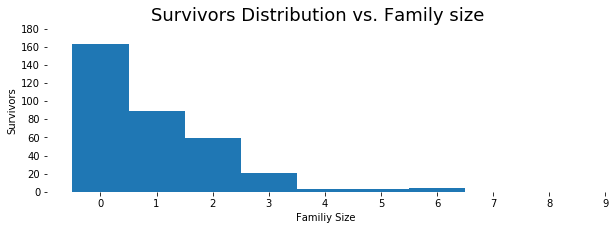

In [12]:
f, ax = plt.subplots(1,1, figsize=(10,3))
sub_train[survivors].loc[:,'Relatives'].plot.hist(bins=np.arange(10)-0.5)
sns.despine(left=True, bottom=True)
f.suptitle('Survivors Distribution vs. Family size', size=18)
ax.set_ylabel('Survivors')
ax.set_xlabel('Familiy Size')
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(0,181,20))
print() # Disables to show the previous outputs

As we see above, the distribution is right skewed. This means that most of the people were on board by them selfs.
If we sort the values (i.e. sort cluster sizes), we will observe that the names should be similar, ordered by last names:

In [13]:
interesting_columns = ['Name', 'Age', 'SibSp', 'Parch', 'Survived']
sub_train[interesting_columns] =  train[interesting_columns].copy()
sub_train.sort_values(by=['Relatives', 'Name'], ascending=False).head(15)

,SibSp,Parch,Survived,Relatives,Name,Age
324,8,2,0,10,"Sage, Mr. George John Jr",-0.5
201,8,2,0,10,"Sage, Mr. Frederick",-0.5
846,8,2,0,10,"Sage, Mr. Douglas Bullen",-0.5
792,8,2,0,10,"Sage, Miss. Stella Anna",-0.5
863,8,2,0,10,"Sage, Miss. Dorothy Edith ""Dolly""",-0.5
180,8,2,0,10,"Sage, Miss. Constance Gladys",-0.5
159,8,2,0,10,"Sage, Master. Thomas Henry",-0.5
678,1,6,0,7,"Goodwin, Mrs. Frederick (Augusta Tyler)",43.0
683,5,2,0,7,"Goodwin, Mr. Charles Edward",14.0
71,5,2,0,7,"Goodwin, Miss. Lillian Amy",16.0


### Observing surviving rates per family size

Now that we have the families grouped together, we can observe what is the survivor rate per family:

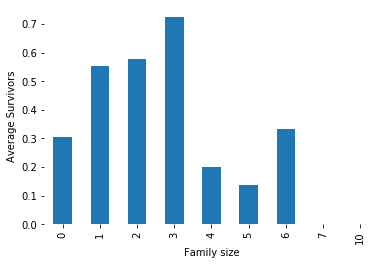

In [14]:
sub_train.pivot_table(index='Relatives',values='Survived').plot.bar()
sns.despine(left=True, bottom=True)
plt.ylabel('Average Survivors')
plt.legend().set_visible(False)
_ = plt.xlabel('Family size')

It seems that small and mid size families had more chances to survive. We will use a new feature which shows if the passenger was alone or not. With an helper function we'll be able to generate this feature for both train and test sets easily.

In [15]:
def alone_on_board(df):
    df['Family size'] = df[['SibSp', 'Parch']].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df['Family size'] == 0),"isalone"] = 1
    df.drop('Family size', axis=1)
    return df

In [16]:
train = alone_on_board(train)
holdout = alone_on_board(holdout)
train.sample(3, random_state=1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,Family size,isalone
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,...,1,0,0,0,0,0,1,0,0,1
223,224,0,3,"Nenkoff, Mr. Christo",male,-0.5,0,0,349234,7.8958,...,0,0,0,0,0,1,0,1,0,1
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,...,0,0,0,0,0,1,1,0,0,1


## Features selection - Optimization

Let's write a function that:

- Performs data preparation for machine learning
- Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features

We will make this by means of scikit-learn's recursive feature elimination and cross-validated selection ([RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)) class to automate selecting the best-performing features using recursive feature elimination. This process is a feature ranking with selection of the best number of features.


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    # Remove any non-numeric columns or columns containing null values
    df = df.select_dtypes([np.number]).dropna(axis=1)

    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns\n",20*'-')
    for c in best_columns:
        print("{}".format(c))
    
    return best_columns

In [18]:
cols = select_features(train)

Best Columns
 --------------------
Pclass
Age
SibSp
Parch
Fare
Age_categories_Missing
Age_categories_Infant
Age_categories_Child
Age_categories_Teenager
Age_categories_Young Adult
Age_categories_Adult
Age_categories_Senior
Fare_categories_0-12
Fare_categories_12-50
Fare_categories_50-100
Fare_categories_100+
Title_Master
Title_Miss
Title_Mr
Title_Mrs
Title_Officer
Title_Royalty
Cabin_type_A
Cabin_type_B
Cabin_type_C
Cabin_type_D
Cabin_type_E
Cabin_type_F
Cabin_type_G
Cabin_type_Unknown
Sex_female
Sex_male
Family size
isalone


We obtained that the 'isalone' feature is helpful after all!

## Model selection - Optimization

We can then use a for loop to iterate over the list of dictionaries, and for each one we can use scikit-learn's [model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class to find the best set of performing parameters, and add values for both the parameter set and the score to the dictionary.

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df,features,target):
    
    all_X = df[features]
    all_y = df[target]

    # List of dictionaries.
    # Each contains a model name, it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LR",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNN Classifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RF Classifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'], '\n', 40*'-')

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {:.2f}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))

    return models

In [24]:
# Test with the optimal columns we found before
models_result = select_model(train,cols,"Survived")

LR 
 ----------------------------------------
Best Score: 0.82
Best Parameters: {'solver': 'lbfgs'}
KNN Classifier 
 ----------------------------------------
Best Score: 0.78
Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
RF Classifier 
 ----------------------------------------
Best Score: 0.84
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}


# Setup a file to submit to Kaggle

In [21]:
def save_submission_file(model,cols,filename="Titanic_submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

In [22]:
best_rf_model = models_result[2]["best_model"]
save_submission_file(best_rf_model,cols)

# PS

The score in Kaggle is 0.77033, great work!